<a href="https://colab.research.google.com/github/BINSHUMESH/ChicagoCrimePrediction/blob/master/chicago_crime_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Mounting the google Drive
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


In [0]:
#importing the Data
import pandas as pd
df=pd.read_csv('Chicago_Crimes_2012_to_2017.csv')
df=df.drop_duplicates()
df=df[df['Year']>2014]

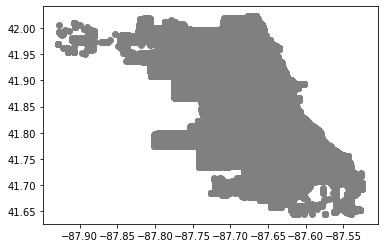

In [0]:
#Visualization of the Longitude and Latitude.
import matplotlib.pyplot as plt
plt.scatter('Longitude', 'Latitude', c='gray', data=df,)
plt.show();

In [0]:
#removing null values and dropping columns
dfn=df.dropna(axis=0,how='any')
dfn=dfn.drop(['Description','ID','Case Number','Location','Updated On','Block'],axis=1)
dfn=dfn.drop(df.columns[0],axis=1)
dfn['Date']=pd.to_datetime(dfn['Date'])

In [0]:
#Extracting the month, hour and minutes from date column
import datetime
dfn['month']=dfn['Date'].dt.month
dfn['day']=dfn['Date'].dt.day
dfn['hour']=dfn['Date'].dt.hour
dfn['minute']=dfn['Date'].dt.minute
dfn['dayOfWeak']=dfn['Date'].dt.dayofweek
dfn['Weekday']=dfn['Date'].dt.weekday
dfn['dayOfYear']=dfn['Date'].dt.dayofyear
dfn['quarter']=dfn['Date'].dt.quarter
dfn['week']=dfn['Date'].dt.week
dfn=dfn.drop(['Date'],axis=1)
dnft=dfn

In [0]:
#Adding severity column and Encoding the categorical values
!pip install category_encoders
dfn=dnft
pd.set_option('display.max_columns',176)
import numpy as np
dfng=dfn.groupby("Primary Type")["Primary Type"].count()
dfng=dfng.sort_values(ascending=False)
dfng.head(50)
crime_list=dfng.index.values[0:26].tolist()

dfn=dfn[dfn["Primary Type"].isin(crime_list)]
#dfn=dfn[dfn["Primary Type"]!="OTHER OFFENSE"]

severe_crime_list=["ARSON", "ASSAULT", "BATTERY", "CRIM SEXUAL ASSAULT", "CRIMINAL DAMAGE", "CRIMINAL TRESPASS", "HOMICIDE", "ROBBERY"]
dfn["severe"]=np.where(dfn['Primary Type'].isin(severe_crime_list), 2, 1)

from sklearn.preprocessing import LabelEncoder
dfn['Arrest']=LabelEncoder().fit_transform(dfn['Arrest'])
# dfn['Domestic']=LabelEncoder().fit_transform(dfn['Domestic'])
# dfn['Primary Type']=LabelEncoder().fit_transform(dfn['Primary Type'])
# dfn['FBI Code']=LabelEncoder().fit_transform(dfn['FBI Code'])
# dfn['IUCR']=LabelEncoder().fit_transform(dfn['IUCR'])
# dfn['Location Description']=LabelEncoder().fit_transform(dfn['Location Description'])
import category_encoders as ce
encoder = ce.BinaryEncoder(cols=['Primary Type'])
dfn= encoder.fit_transform(dfn)
encoder = ce.BinaryEncoder(cols=['FBI Code'])
dfn= encoder.fit_transform(dfn)
encoder = ce.BinaryEncoder(cols=['IUCR'])
dfn= encoder.fit_transform(dfn)
encoder = ce.BinaryEncoder(cols=['Location Description'])
dfn= encoder.fit_transform(dfn)
# encoder = ce.BinaryEncoder(cols=['Block'])
# dfn= encoder.fit_transform(dfn)

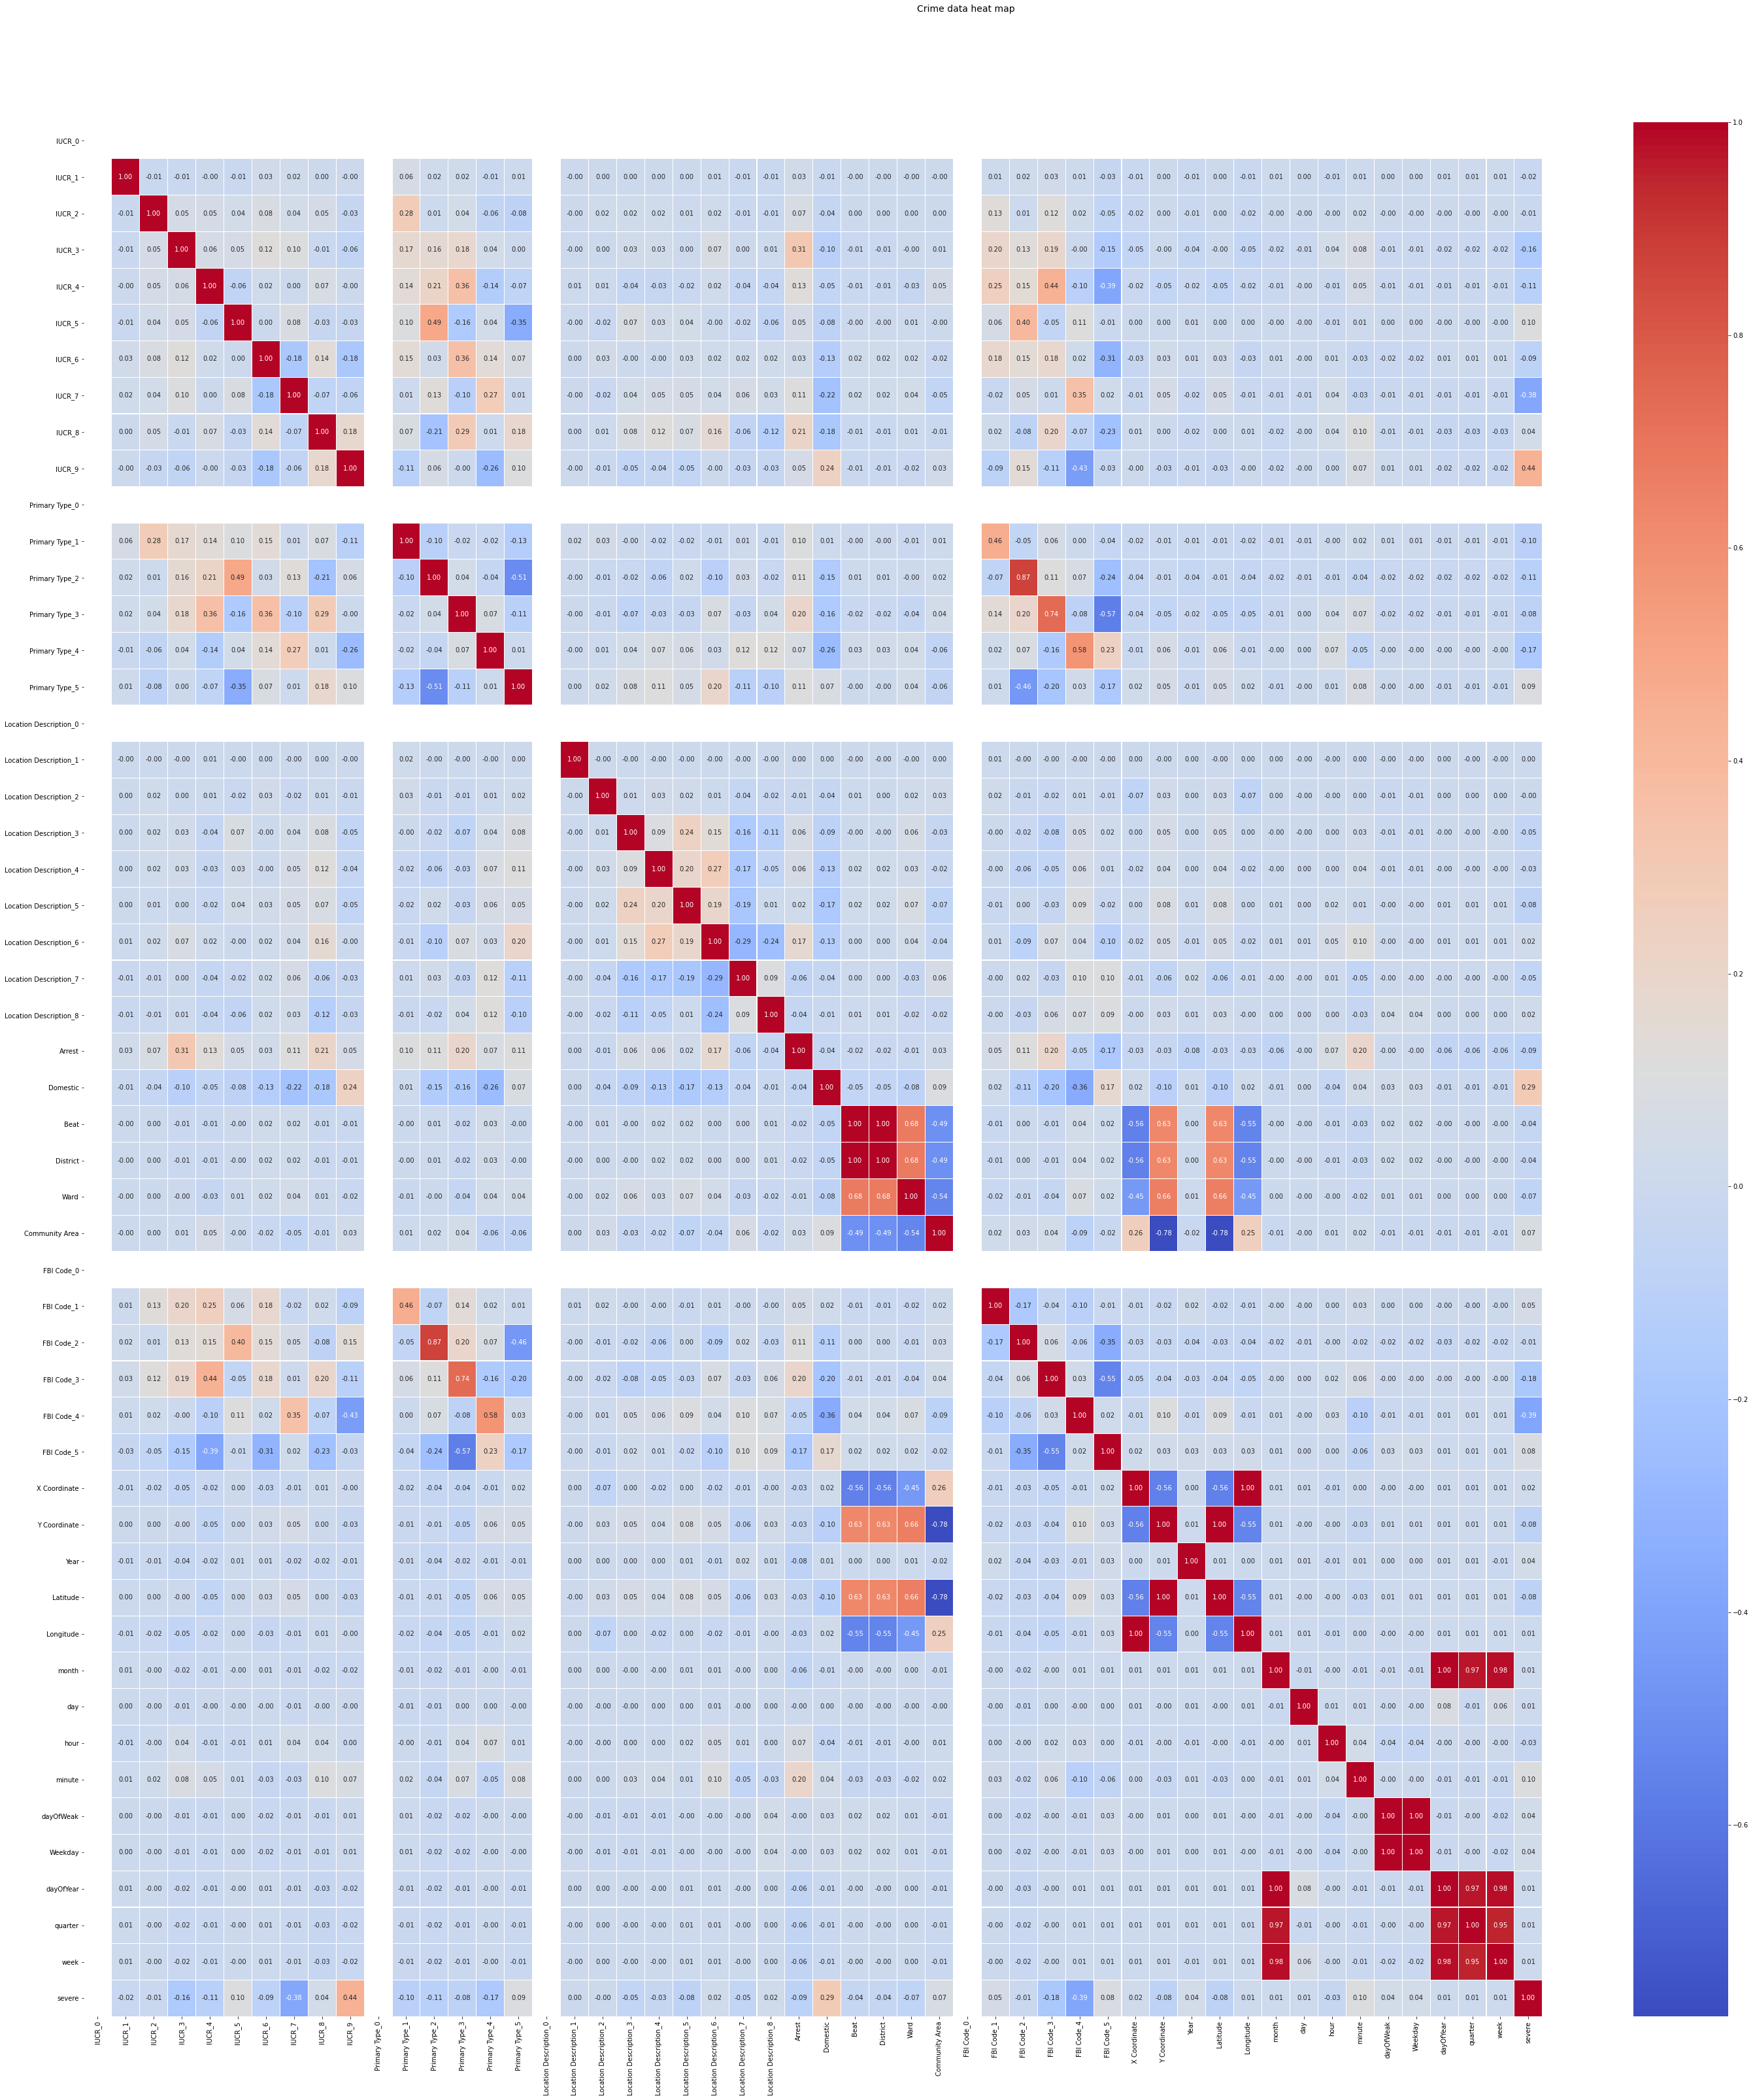

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import numpy as np
import seaborn as sns
%matplotlib inline

# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(50,50))
corr = dfn.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Crime data heat map', fontsize=14)


In [0]:
#Splitting the data into train and test in stratify mode
from sklearn.model_selection import train_test_split
arrestIndex=dfn.columns.get_loc("Arrest")
takeIndex=[]
for i in range(52):
  if(i!=arrestIndex):
    takeIndex.append(i)
X=dfn.iloc[:,takeIndex]
Y=dfn.iloc[:,arrestIndex]
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,stratify=Y)
X_train,X_val,Y_train,Y_val=train_test_split(X_train,Y_train,test_size=0.20,stratify=Y_train)

0.7117442744799793
0.7694738245140854
0.7476772539457281
0.7743662921524506
0.7632014301059251
0.7781140478113264
0.7709635181860235
0.7798389562735705
0.7757618999082663
0.7815638647358146
0.777706342174796
0.7822930305857633
0.7798546372595909
0.7835083070023443
0.7814933002987228
0.7835710309464259
0.7819950918513756
0.7837121598206095
0.7825988098131611
0.784198270387242


Text(0, 0.5, 'Accuracy')

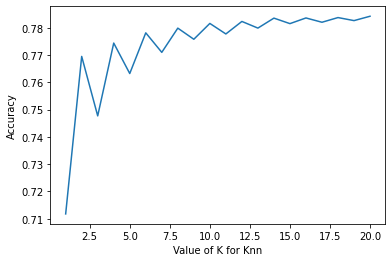

In [19]:
#KNN model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
k_range=range(1,21)
scores={}
score_list=[]
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors = k).fit(X_train, Y_train)
  Y_pred=knn.predict(X_test)
  scores[k]=metrics.accuracy_score(Y_pred,Y_test)
  print(scores[k])
  score_list.append(scores[k])
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(k_range,score_list)
plt.xlabel('Value of K for Knn')
plt.ylabel('Accuracy')

In [20]:
from xgboost import XGBClassifier
#making the instance of model
model = XGBClassifier()
model.fit(X_train, Y_train)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

#evaluate predictions
from sklearn import metrics
accuracy = metrics.accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.97%


In [23]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(X_train, Y_train)
# Actual class predictions
rf_predictions = model.predict(X_test)
# Probabilities for each class
rf_probs = model.predict_proba(X_test)[:, 1]
print(metrics.accuracy_score(Y_test,rf_predictions))

0.892569564774233


In [24]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train=X_train.values
Y_train=Y_train.values
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, Y_train)
predictions=logisticRegr.predict(X_test)
print(metrics.accuracy_score(Y_test,predictions))

0.7717867699520946


In [26]:
from sklearn import model_selection 
from sklearn.ensemble import BaggingClassifier 
from sklearn.tree import DecisionTreeClassifier 
seed = 8
kfold = model_selection.KFold(n_splits = 3, random_state = seed)
base_cls = DecisionTreeClassifier()

# no. of base classifier 
num_trees = 10
  
# bagging classifier 
model = BaggingClassifier(base_estimator = base_cls, 
                          n_estimators = num_trees, 
                          random_state = seed) 
  
results = model_selection.cross_val_score(model, X, Y, cv = kfold) 
print("accuracy :") 
print(results.mean()) 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


accuracy :
0.8761373865573366
